The data of the clique graph for the molecular docking are taken from this paper [https://arxiv.org/pdf/2308.04098]

In [1]:
import cudaq
from cudaq import spin
import numpy as np

# GPU: Default If an NVIDIA GPU and CUDA runtime libraries are available
#cudaq.set_target('nvidia')

# CPU
cudaq.set_target('qpp-cpu')


In [2]:
# The two graphs input from the paper

# BIG 1

nodes = [0,1,2,3,4,5]
qubit_num=len(nodes)
edges = [[0,1],[0,2],[0,4],[0,5],[1,2],[1,3],[1,5],[2,3],[2,4],[3,4],[3,5],[4,5]]
non_edges = [[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
print('Edges: ', edges)
print('Non-Edges: ', non_edges)
weights = [0.6686,0.6686,0.6686,0.1453,0.1453,0.1453]
penalty = 6.0
num_layers = 3

# BIG 2 (More expensive simulation)

#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6886,0.1091,0.0770,0.0770,0.0770,0.0770]
#penalty=8.0
#num_layers=8

Edges:  [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-Edges:  [[0, 3], [1, 4], [2, 5]]


In [3]:
# Generate the Hamiltonian
def ham_clique(penalty, nodes, weights, non_edges)-> cudaq.SpinOperator:

    spin_ham = 0.0
    for wt,node in zip(weights,nodes):
        #print(wt,node)
        spin_ham += 0.5 * wt * spin.z(node)
        spin_ham -= 0.5 * wt * spin.i(node)

    for non_edge in non_edges:
        u,v=(non_edge[0],non_edge[1])
        #print(u,v)
        spin_ham += penalty/4.0 * (spin.z(u)*spin.z(v)-spin.z(u)-spin.z(v)+spin.i(u)*spin.i(v))

    return spin_ham

In [4]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def term_coefficients(ham: cudaq.SpinOperator) -> list[complex]:
    result = []
    ham.for_each_term(lambda term: result.append(term.get_coefficient()))
    return result

    # Collect Pauli words from a spin operator so we can pass them to a kernel
def term_words(ham: cudaq.SpinOperator) -> list[str]:
    result = []
    ham.for_each_term(lambda term: result.append(term.to_string(False)))
    return result

In [5]:
@cudaq.kernel
def dc_qaoa(qubit_num:int, num_layers:int,thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):

    qubits=cudaq.qvector(qubit_num)

    h(qubits)

    count=0
    for p in range(num_layers):

        for i in range(len(coef)):
            exp_pauli(thetas[count]*coef[i].real,qubits,words[i])
            count+=1

        for j in range(qubit_num):
            rx(thetas[count],qubits[j])
            count+=1

        for k in range(qubit_num):
            ry(thetas[count],qubits[k])
            count+=1

In [6]:
ham= ham_clique(penalty,nodes,weights,non_edges)
print(ham)

# coef=term_coefficients(ham)
# words=term_words(ham)

# I copied this from tutorial
coef= [(1.5+0j), (1.5+0j), (-1.1657+0j), (1.5+0j), (-1.42735+0j), (3.2791499999999996+0j), (-1.1657+0j), (-1.42735+0j), (-1.1657+0j), (-1.42735+0j)]
words= ['IIZIIZ', 'ZIIZII', 'IZIIII', 'IZIIZI', 'IIIZII', 'IIIIII', 'IIZIII', 'IIIIIZ', 'ZIIIII', 'IIIIZI']

print(term_coefficients(ham))
print(term_words(ham))

(0+0i) + (-1.1657+0i) * Z0 + (-0.3343+0i) * I0 + (-1.1657+0i) * Z1 + (-0.3343+0i) * I1 + (-1.1657+0i) * Z2 + (-0.3343+0i) * I2 + (-1.42735+0i) * Z3 + (-0.07265+0i) * I3 + (-1.42735+0i) * Z4 + (-0.07265+0i) * I4 + (-1.42735+0i) * Z5 + (-0.07265+0i) * I5 + (1.5+0i) * Z0Z3 + (1.5+0i) * I0I3 + (1.5+0i) * Z1Z4 + (1.5+0i) * I1I4 + (1.5+0i) * Z2Z5 + (1.5+0i) * I2I5
[0j, (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j)]
['', 'Z', 'I', 'IZ', 'II', 'IIZ', 'III', 'IIIZ', 'IIII', 'IIIIZ', 'IIIII', 'IIIIIZ', 'IIIIII', 'ZIIZ', 'IIII', 'IZIIZ', 'IIIII', 'IIZIIZ', 'IIIIII']


/tmp/ipykernel_20465/2582099611.py:4: DeprecationWarning: use standard iteration instead
  ham.for_each_term(lambda term: result.append(term.get_coefficient()))
/tmp/ipykernel_20465/2582099611.py:4: DeprecationWarning: use `evaluate_coefficient` on each term (product operator) instead
  ham.for_each_term(lambda term: result.append(term.get_coefficient()))
/tmp/ipykernel_20465/2582099611.py:10: DeprecationWarning: use standard iteration instead
  ham.for_each_term(lambda term: result.append(term.to_string(False)))
/tmp/ipykernel_20465/2582099611.py:10: DeprecationWarning: use overload without boolean argument or `get_pauli_word` on each term instead
  ham.for_each_term(lambda term: result.append(term.to_string(False)))


In [7]:
# Optimizer

# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.NelderMead()
#optimizer = cudaq.optimizers.COBYLA()

np.random.seed(13)
cudaq.set_random_seed(13)

# if dc_qaoa used
parameter_count=(2*qubit_num+len(coef))*num_layers

# if qaoa used
# parameter_count=(qubit_num+len(coef))*num_layers

print('Total number of parameters: ', parameter_count)
optimizer.initial_parameters = np.random.uniform(-np.pi/8 , np.pi/8 ,parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Total number of parameters:  66
Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806, 0.3527177454825464, -0.22156160012057186, -0.1418496891385843, 0.32811766468303116, -0.367642000671186, -0.34158180583996006, 0.10196745745501312, 0.29359239180502594, -0.3858537615546677, 0.19366130907065582, 0.24570488114056754, -0.3332307385378807, 0.12287973244618389, 0.007274514934614895, -0.015799547372526146, 0.3578070967202224, -0.39268963055535144, -0.19872246354138554, 0.16668715544467982, -0.13777293592446055, -0.17514665212709513, 0.15350249947988204, 0.32872977428061945, -0.20068831419712105, -0.0329193

In [8]:
cost_values=[]
def objective(parameters):

    cost=cudaq.observe(dc_qaoa, ham, qubit_num, num_layers, parameters,coef,words).expectation()
    cost_values.append(cost)
    return cost

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)

optimal_expectation = -2.0057970170760537
optimal_parameters = [2.0617900450255213, -0.008832997414504553, 0.5446745231437978, 0.9170743966952536, 0.5684145055308018, 0.45653992738579674, 0.48765328828009236, 0.08690545932812363, 0.4396413285058074, 0.18459993158979182, -1.309747594917737, 1.2588385005776594, -0.834255663515425, 0.674712608431175, -0.40174553656823186, 0.1936475123928361, 0.11292461472367524, -0.40520422214477836, 0.5249647407525035, -0.8276837818165452, 0.2945660883282474, -0.8060498989662159, 0.08051672267342141, 0.016438756265571293, 1.5245041151262497, 1.4087477995498743, 0.24688680789607903, 2.1121838066265077, 1.1445970943333728, -0.22281558391261153, 0.29034932090910637, -1.0492037973620043, 0.2734013684834806, 0.5265417924961102, 0.5099056677967553, 0.8636684922225737, -0.6164906874232119, -0.42851259141848624, 0.09675272347583658, 0.05697275350531247, -0.7102412317670379, -0.11174687408874051, 0.32505750242276577, -0.4397450017834574, -0.023604090020531092, 2.

In [14]:
shots=10000

counts = cudaq.sample(dc_qaoa, qubit_num, num_layers, optimal_parameters,coef,words, shots_count=shots)
print(counts)

print('The MVWCP is given by the partition: ', max(counts, key=lambda x: counts[x]))

# Alternative
print('The MVWCP is given by the partition: ', counts.most_probable())

{ 111000:10000 }

The MVWCP is given by the partition:  111000
The MVWCP is given by the partition:  111000


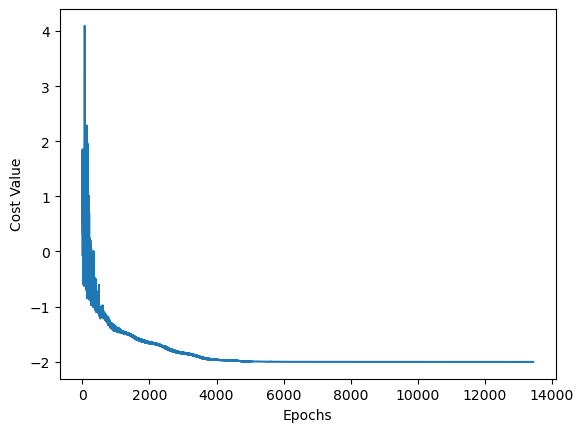

In [15]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()